In [418]:
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.cluster import KMeans #import k-means clustering
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist, pdist


In [437]:
def elbow_scores(data, max_num, min_num=1):
    avgs = pd.DataFrame(columns=['cluster_num', 'score'])

    for n in range(min_num,max_num+1):
        km_elbow = KMeans(n_clusters=n).fit(data) 
        centroids = [km_elbow.cluster_centers_]
        Dists_k = [cdist(data, cent, 'euclidean') for cent in centroids]

        dist = [np.min(D,axis=1) for D in Dists_k]
        avg = [sum(d)/data.shape[0] for d in dist]
        avgs = avgs.append({'cluster_num': n, 'score': avg[0]}, ignore_index=True)
    #return avgs

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.set_title("Elbow Scores", fontsize=18)
    ax.set_xlabel("Cluster Number")
    ax.set_ylabel("Avg Within SS")
    ax.plot(avgs.cluster_num, avgs.score,'r-')

def get_kmeans_labels(data, num_clusters):
    km = KMeans(n_clusters=num_clusters) 
    results=km.fit(data) 
    return results.labels_

def massage_original_data(data):
    data = data.sort_values(by=['price'])
    data = data[data['price'] != 'MISSING'] ## NOTE: filters out MISSING prices 
    data['price_cat'] = pd.factorize(data['price'])[0]+1
    ## $= under $10. $$=11-30. $$$=31-60. $$$$= over $61.
    data.loc[data['price'] == '$', 'price'] = 10
    data.loc[data['price'] == '$$', 'price'] = 20
    data.loc[data['price'] == '$$$', 'price'] = 45
    data.loc[data['price'] == '$$$$', 'price'] = 65
    data['NTACode_fact'] = pd.factorize(data['NTACode'])[0]+1
    return data

def normalize_data(data):
    data['latitude']  =(data['latitude']  -data['latitude'].mean())  /data['latitude'].std()
    data['longitude'] =(data['longitude'] -data['longitude'].mean()) /data['longitude'].std()
    data['review_cou']=(data['review_cou']-data['review_cou'].mean())/data['review_cou'].std()
    return data

In [438]:
# data paths
data_path = "./data"
Yelp_BK_path = data_path +  "/Yelp/BK/"
Yelp_MN_path = data_path + "/Yelp/MN/"
path_census_tracts = './data/ACS/CensusTracts'

In [439]:
columns = ['latitude', 'longitude','review_cou','rating']
# columns = ['review_cou','rating', 'price_cat']
cols_analysis = ['cluster','review_cou','rating','price']

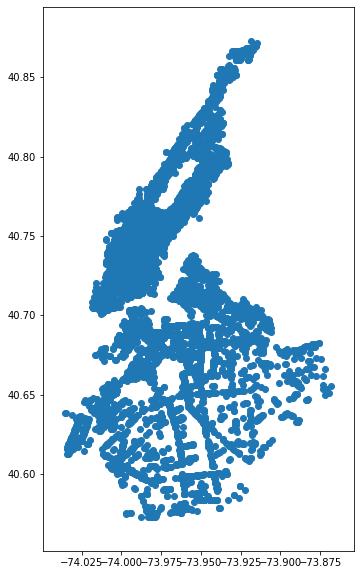

In [440]:
# Reading in Yelp shapefiles 
MN_Yelp = gpd.read_file(Yelp_MN_path + "MN_Yelp_CensusTract_NTA.shp")
BK_Yelp = gpd.read_file(Yelp_BK_path + "BK_Yelp_CensusTract_NTA.shp")

NY_Yelp = MN_Yelp.append([BK_Yelp],sort='True')
NTA = gpd.read_file('data/NTA/nynta.shp')

MN_Yelp = massage_original_data(MN_Yelp)
BK_Yelp = massage_original_data(BK_Yelp)
NY_Yelp = massage_original_data(NY_Yelp)

f, ax = plt.subplots(figsize=(10, 10))
NY_Yelp.plot(ax=ax)

In [441]:
print(NY_Yelp.columns)

Index(['0-25k', '100-125k', '100k-125k', '125-150k', '125k-150k', '25-50k',
       '25k-50k', '50-75k', '50k-75k', '75-100k', '75k-100k', '> 150k',
       'Households', 'MeanLifeEx', 'NTACode', 'NTAName', 'address', 'alias',
       'categories', 'city', 'country', 'geometry', 'id', 'index_righ',
       'is_closed', 'latitude', 'longitude', 'name', 'price', 'rating',
       'review_cou', 'state', 'zipcode', 'price_cat', 'NTACode_fact'],
      dtype='object')


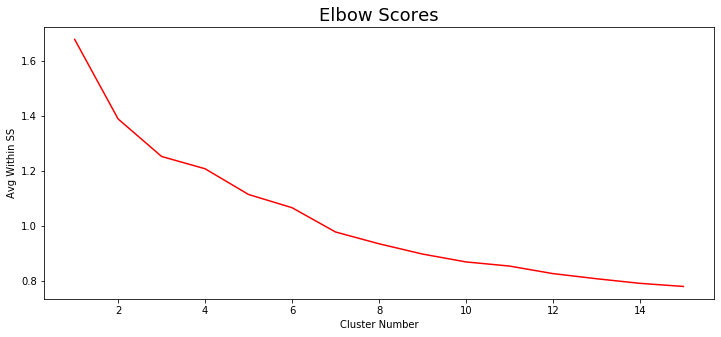

In [442]:
BK_Yelp_sub = BK_Yelp[columns].copy()
BK_Yelp_std = normalize_data(BK_Yelp_sub)

elbow_scores(BK_Yelp_std, 15)

review_cou                     rating                   price  \
             count        mean     sum  count      mean     sum count   
cluster                                                                 
0             1470   78.228571  114996   1470  3.508163  5157.0  1470   
1             1026   38.874269   39885   1026  3.003899  3082.0  1026   
2             1748  228.081236  398686   1748  3.902460  6821.5  1748   

                           
              mean    sum  
cluster                    
0        16.017007  23545  
1        13.879142  14240  
2        18.054920  31560

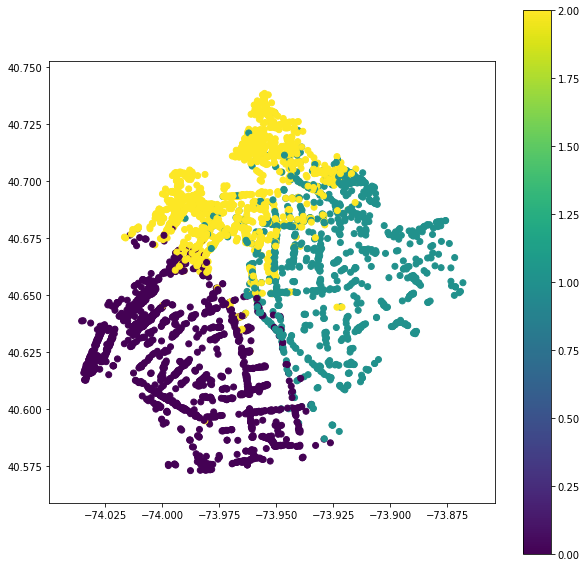

In [443]:
labels = get_kmeans_labels(BK_Yelp_sub, 3)
BK_Yelp['cluster'] = labels

f, ax = plt.subplots(figsize=(10, 10))
BK_Yelp.plot(ax=ax, column='cluster', legend=True)

BK_Yelp[cols_analysis].groupby(['cluster']).agg(['count','mean','sum'])

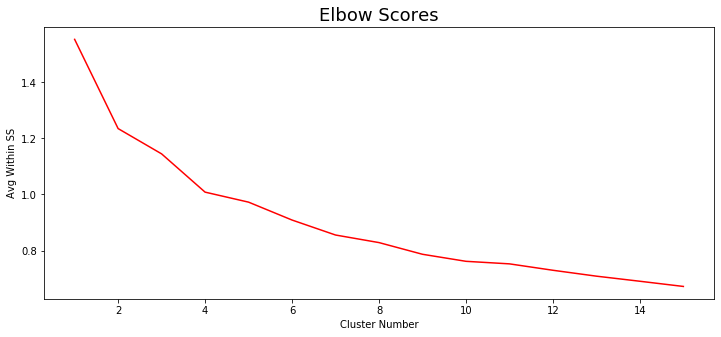

In [444]:
MN_Yelp_sub = MN_Yelp[columns].copy()
MN_Yelp_std = normalize_data(MN_Yelp_sub)

elbow_scores(MN_Yelp_std, 15)

review_cou                      rating                    price  \
             count         mean     sum  count      mean      sum count   
cluster                                                                   
0             2808   249.881054  701666   2808  3.698362  10385.0  2808   
1             1384   136.807081  189341   1384  3.460983   4790.0  1384   
2             3156   196.809886  621132   3156  3.424588  10808.0  3156   
3              330  1891.215152  624101    330  3.918182   1293.0   330   

                           
              mean    sum  
cluster                    
0        20.667735  58035  
1        16.907514  23400  
2        21.180292  66845  
3        26.469697   8735

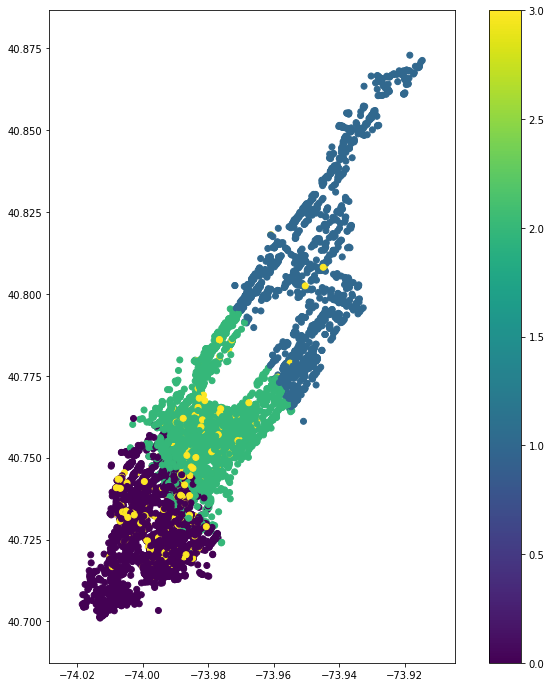

In [445]:
labels = get_kmeans_labels(MN_Yelp_std, 4)
MN_Yelp['cluster'] = labels

f, ax = plt.subplots(1, figsize=(12, 12))
MN_Yelp.plot(ax=ax, column='cluster', legend=True)

MN_Yelp[cols_analysis].groupby(['cluster']).agg(['count','mean','sum'])

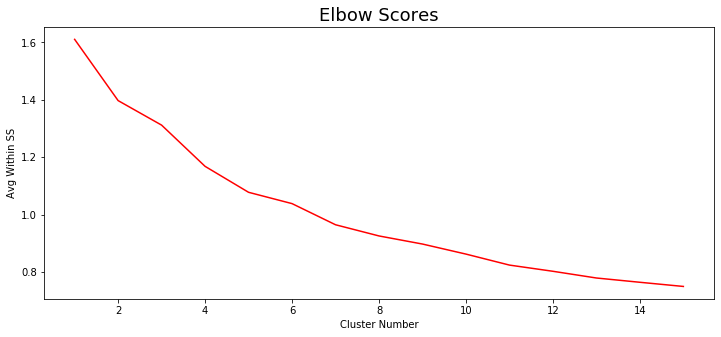

In [446]:
NY_Yelp_sub = NY_Yelp[columns].copy()
NY_Yelp_std = normalize_data(NY_Yelp_sub)

elbow_scores(NY_Yelp_std, 15)

review_cou                       rating                    price  \
             count         mean      sum  count      mean      sum count   
cluster                                                                    
0             6002   226.943519  1362115   6002  3.587804  21534.0  6002   
1             1984    94.735887   187956   1984  3.503528   6951.0  1984   
2             1852   133.920626   248021   1852  3.431695   6355.5  1852   
3              404  1813.769802   732763    404  3.903465   1577.0   404   
4             1680    94.614286   158952   1680  3.523214   5919.0  1680   

                            
              mean     sum  
cluster                     
0        20.732256  124435  
1        15.625000   31000  
2        18.045356   33420  
3        26.014851   10510  
4        16.068452   26995

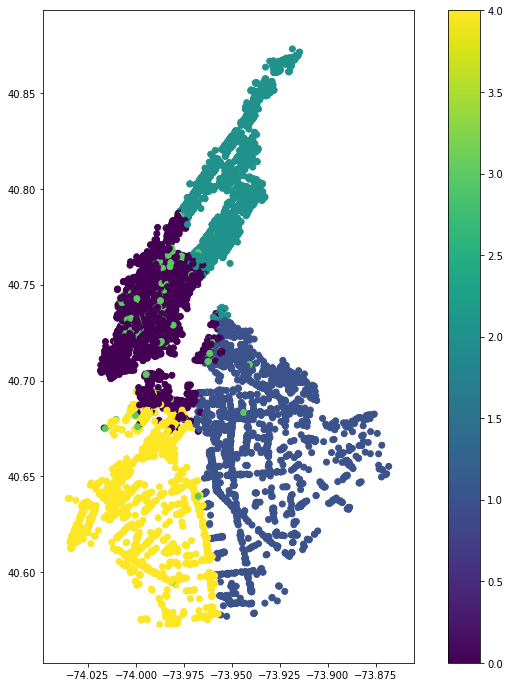

In [447]:
labels = get_kmeans_labels(NY_Yelp_std, 5)
NY_Yelp['cluster'] = labels

f, ax = plt.subplots(1, figsize=(12, 12))
NY_Yelp.plot(ax=ax, column='cluster', legend=True)

NY_Yelp[cols_analysis].groupby(['cluster']).agg(['count','mean','sum'])

In [448]:
# lET'S ADD THE NTA DATA 
MN_NTA_Yelp = pd.merge(MN_Yelp, NTA, on='NTACode', how='left')
BK_NTA_Yelp = pd.merge(BK_Yelp, NTA, on='NTACode', how='left')
NY_NTA_Yelp = pd.merge(NY_Yelp, NTA, on='NTACode', how='left')

MN_NTA_Yelp['geometry'] = MN_NTA_Yelp['geometry_y']
BK_NTA_Yelp['geometry'] = BK_NTA_Yelp['geometry_y']
NY_NTA_Yelp['geometry'] = NY_NTA_Yelp['geometry_y']

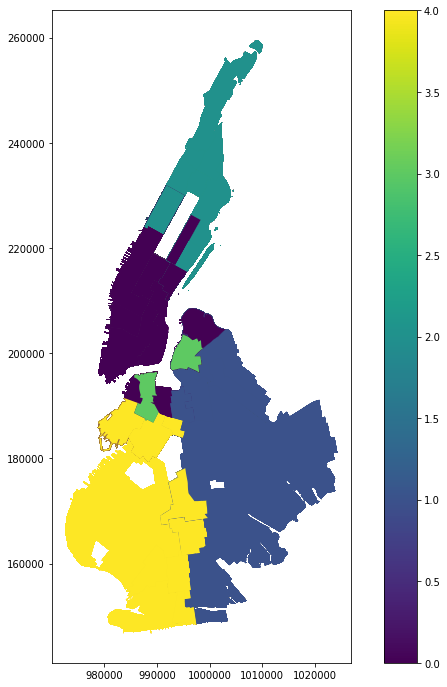

In [449]:
f, ax = plt.subplots(1, figsize=(12, 12))
NY_NTA_Yelp.plot(ax=ax, column='cluster', legend=True)

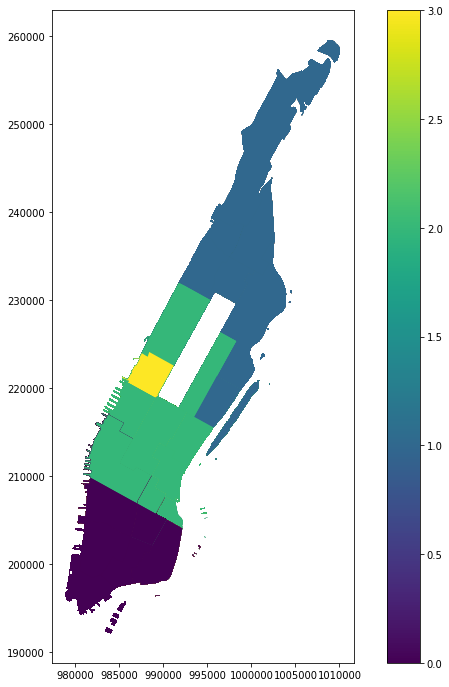

In [450]:
f, ax = plt.subplots(1, figsize=(12, 12))
MN_NTA_Yelp.plot(ax=ax, column='cluster', legend=True)

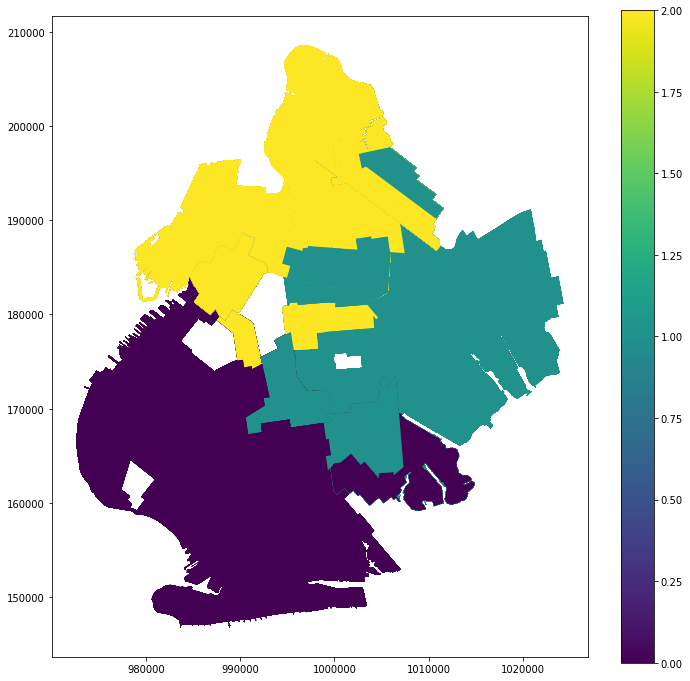

In [451]:
f, ax = plt.subplots(1, figsize=(12, 12))
BK_NTA_Yelp.plot(ax=ax, column='cluster', legend=True)